## Ranked Scatter Plot of cell population feature importance

### Top cell populations by consistent importance

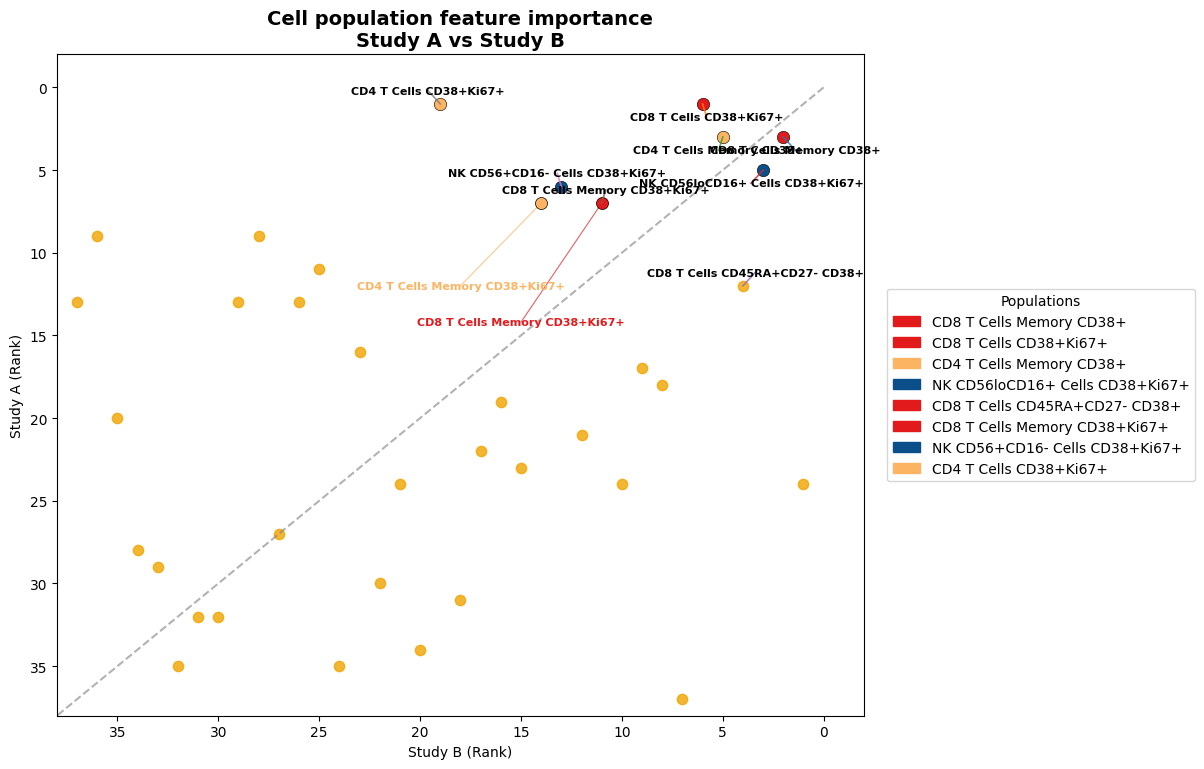

In [40]:
#Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
#Read and merge data
studyA_path = "univariate_importance_regressor_WCCT.csv"
studyB_path = "univariate_importance_regressor_VXA.csv"
out_path = "Ranked_R2_from_rho_BL2_reset.png"
a = pd.read_csv(studyA_path)
b = pd.read_csv(studyB_path)
merged = pd.merge(
    a[["population", "R2_from_rho"]],
    b[["population", "R2_from_rho"]],
    on="population",
    suffixes=("_A", "_B")
)

#Ranking
merged["rank_A"] = merged["R2_from_rho_A"].rank(ascending=False, method="min")
merged["rank_B"] = merged["R2_from_rho_B"].rank(ascending=False, method="min")
eps = 1e-12
denom = merged[["R2_from_rho_A", "R2_from_rho_B"]].max(axis=1) + eps
merged["similarity"] = 1.0 - (merged["R2_from_rho_A"] - merged["R2_from_rho_B"]).abs() / denom
importance = merged[["R2_from_rho_A", "R2_from_rho_B"]].mean(axis=1)
merged["combined_score"] = merged["similarity"] * importance
top6 = merged.nlargest(6, "combined_score")

# Color map
color_map = {
    "CD8": "#e31a1c",
    "CD4": "#fdb462",
    "NK": "#0b4f8a",
    "B": "#1f78b4",
    "Mono": "#b2df8a",
    "Gran": "#fb9a99",
    "Dend": "#a65628"
}
def get_color(label):
    for key, col in color_map.items():
        if key.lower() in label.lower():
            return col
    return "#f0a400"
    
#Plotting
fig, ax = plt.subplots(figsize=(7.5, 6))
ax.scatter(merged["rank_B"], merged["rank_A"], color="#f0a400", alpha=0.8, s=55)
lim_max = max(merged["rank_A"].max(), merged["rank_B"].max()) + 1
ax.plot([0, lim_max], [0, lim_max], "--", color="gray", alpha=0.6)
xs, ys, labels, colors = [], [], [], []
for _, row in top6.iterrows():
    xs.append(row["rank_B"])
    ys.append(row["rank_A"])
    labels.append(row["population"])
    col = get_color(row["population"])
    colors.append(col)
    ax.scatter(row["rank_B"], row["rank_A"], s=80, color=col,
               edgecolor="black", linewidth=0.4, zorder=5)
    
# Label placement
def place_labels_radially(ax, xs, ys, labels, colors):
    custom_offsets = {
        "CD4 T Cells CD38+Ki67+": (-1.0, 3.0),
        "CD4 T Cells Memory CD38+": (3.5, 2.0),
        "CD4 T Cells Memory CD38+Ki67+": (4.0, -6.0),
        "CD8 T Cells CD38+Ki67+": (5.0, 1.5),
        "CD8 T Cells Memory CD38+": (3.0, -1.8),
        "NK CD56+CD16- Cells CD38+Ki67+": (5.5, -5.5),
        "NK CD56loCD16+ Cells CD38+Ki67+": (-5.2, 0.8)
    }

    for (xv, yv, label, col) in zip(xs, ys, labels, colors):
        dx, dy = custom_offsets.get(label, (3.0, 2.0))
        ax.plot([xv, xv + dx], [yv, yv + dy],
                color=col, linewidth=1.0, alpha=0.85, zorder=3)
        ax.text(xv + dx, yv + dy, label, fontsize=8, weight="bold",
                color=col, ha="center", va="center", clip_on=False, zorder=5)
threshold = 0.015
extra = merged.query("combined_score >= @threshold and R2_from_rho_B > 0.02").copy()
extra = extra[~extra["population"].isin(top6["population"])]
extra = extra.reset_index(drop=True)
base_dx, base_dy, spacing = 4.0, 5.0, 2.2
for i, (_, row) in enumerate(extra.iterrows()):
    label = row["population"]
    x, y = row["rank_B"], row["rank_A"]
    color = get_color(label)
    dx, dy = base_dx, base_dy + i * spacing
    ax.scatter(x, y, s=75, color=color, edgecolor="black", linewidth=0.5, zorder=3)
    ax.plot([x, x + dx], [y, y + dy], color=color, linewidth=0.8, alpha=0.7, zorder=2)
    ax.text(x + dx, y + dy, label, fontsize=8, weight="bold",
            color=color, ha="center", va="center", zorder=5)
    
# Axes formatting
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_title("Cell population feature importance\nStudy A vs Study B",
             fontsize=14, weight="bold")
ax.set_xlabel("Study B (Rank)")
ax.set_ylabel("Study A (Rank)")
ax.set_xlim(38, -2)
ax.set_ylim(38, -2)
ax.set_xticks(range(0, 36, 5))
ax.set_yticks(range(0, 36, 5))
ax.tick_params(axis="both", which="major", labelsize=10)
fig.set_size_inches(8.5, 7.5)
plt.tight_layout(rect=[-0.02, -0.02, 1.02, 1.02])

N_LABELS = 8
label_df = merged.dropna(subset=["rank_A", "rank_B", "population"]).copy()
label_df["rank_sum"] = label_df["rank_A"] + label_df["rank_B"]
label_df = label_df.sort_values("rank_sum", ascending=True).head(N_LABELS)
offsets = [(-0.6, 0.8), (-0.2, 0.8), (0.2, 0.8), (0.6, 0.8),
           (-0.6, -0.8), (-0.2, -0.8), (0.2, -0.8), (0.6, -0.8)]
legend_lines = []
for j, (_, row) in enumerate(label_df.iterrows()):
    x = row["rank_B"]
    y = row["rank_A"]
    dx, dy = offsets[j] if j < len(offsets) else (0.3, 0.6)
    pop = str(row["population"])
    col = get_color(pop)
    ax.plot([x, x + dx], [y, y + dy], linewidth=1.2, alpha=0.8, zorder=9)
    ax.text(x + dx, y + dy, pop, fontsize=8, weight="bold",
            ha="center", va="center", zorder=10)
    legend_lines.append((mpatches.Patch(color=col), pop))
handles = [h for h, _ in legend_lines]
labels  = [l for _, l in legend_lines]
ax.legend(handles, labels, title="Populations", loc="center left",
          bbox_to_anchor=(1.02, 0.5), frameon=True)

plt.show()